In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("FlightDelay-SparkSQL-Preprocessing")
    .master("spark://spark-master:7077")
    .config("spark.sql.shuffle.partitions", "6")
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)

print("Spark SQL preprocessing started")
print(f"Spark UI: http://localhost:4040")

Spark SQL preprocessing started
Spark UI: http://localhost:4040


## Step 2-3: Data Loading on Each Node:
Each node (master and workers) will load its part of the dataset into Spark. Once the
data is loaded, Spark will combine the dataset into a unified DataFrame across all
nodes.

In [8]:
import socket

hostname = socket.gethostname()
print(f"I am running on: {hostname}")

part_map = {
    "spark-master":  "/data/part1.csv",
    "spark-worker1": "/data/part2.csv",
    "spark-worker2": "/data/part3.csv"
}

my_file = part_map.get(hostname, "/data/part1.csv")
df_my_part = spark.read.csv(my_file, header=True, inferSchema=True)

print(f"I only loaded: {my_file}")
print(f"Rows in my part: {df_my_part.count():,}")

I am running on: spark-master
I only loaded: /data/part1.csv
Rows in my part: 201,921


In [10]:
# Union everything (normal way)
df_full = spark.read.csv("/data/part*.csv", header=True, inferSchema=True)
print(f"Full unified dataset: {df_full.count():,}")

Full unified dataset: 605,765


## Step 4: Repartition using Spark SQL + cache for parallel processing

In [ ]:
clean_df = spark.table("flights_raw") \
    .where("Cancelled = 0 AND Diverted = 0 AND ArrDelay IS NOT NULL") \
    .selectExpr(
        "CAST(ArrDelay AS DOUBLE) AS label",
        "CAST(DepDelay AS DOUBLE) AS DepDelay",
        "CAST(Distance AS DOUBLE) AS Distance",
        "CAST(TaxiIn AS DOUBLE) AS TaxiIn",
        "CAST(TaxiOut AS DOUBLE) AS TaxiOut",
        "UniqueCarrier",
        "Origin",
        "Dest",
        "DayOfWeek"
) \
    .repartition(6) \
    .cache()

print(
    f"Dataset repartitioned into {clean_df.rdd.getNumPartitions()} partitions")
print(f"Rows after filtering: {clean_df.count():,}")

Dataset repartitioned into 6 partitions
Rows after filtering: 587,130


## Step 4: cleaning + exploration + feature engineering

In [12]:
# Pure Spark SQL: cleaning + exploration + feature engineering
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW flights_sql AS
SELECT 
    CAST(ArrDelay AS DOUBLE) AS label,
    CAST(DepDelay AS DOUBLE) AS DepDelay,
    CAST(Distance AS DOUBLE) AS Distance,
    CAST(TaxiIn AS DOUBLE) AS TaxiIn,
    CAST(TaxiOut AS DOUBLE) AS TaxiOut,
    UniqueCarrier,
    Origin,
    Dest,
    DayOfWeek,
    -- Feature engineering with SQL
    CASE WHEN DayOfWeek IN (6,7) THEN 1.0 ELSE 0.0 END AS IsWeekend,
    Distance * 1.60934 AS Distance_km,
    DepDelay > 15 AS WasDepartureDelayed
FROM flights_raw
WHERE Cancelled = 0 AND Diverted = 0 AND ArrDelay IS NOT NULL
""")

# Quick exploration with SQL
spark.sql("SELECT COUNT(*) AS total_flights FROM flights_sql").show()
spark.sql("SELECT AVG(label) AS avg_delay_min FROM flights_sql").show()
spark.sql("SELECT UniqueCarrier, AVG(label) AS avg_delay, COUNT(*) AS flights FROM flights_sql GROUP BY UniqueCarrier ORDER BY avg_delay DESC LIMIT 10").show()

+-------------+
|total_flights|
+-------------+
|       587130|
+-------------+



+------------------+
|     avg_delay_min|
+------------------+
|10.188855960349496|
+------------------+



+-------------+------------------+-------+
|UniqueCarrier|         avg_delay|flights|
+-------------+------------------+-------+
|           UA| 19.83305925560489|  36486|
|           OO|18.224468614180378|  46247|
|           MQ|15.115856940163413|  40878|
|           AA|15.071998420221169|  50640|
|           YV|14.497241846511178|  20666|
|           9E|12.267573066962633|  21624|
|           XE| 9.886929702048418|  34368|
|           NW| 9.394402118824184|  30583|
|           EV|  9.17060833902939|  21945|
|           CO| 9.002926320853042|  24946|
+-------------+------------------+-------+



## 5. Machine Learning Pipeline:
Once the data is prepared, you will implement a machine learning pipeline using
Spark MLlib. This pipeline will include:
- Feature transformations (e.g., scaling, vectorizing features). 
- Model training: Train a machine learning model (e.g., logistic regression,decision tree, or random forest) on the distributed dataset.
- Model evaluation: Evaluate the trained model's performance using metrics like accuracy, precision, or F1-score.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Categorical columns to index
cat_cols = ["UniqueCarrier", "Origin", "Dest"]

indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep")
    for col in cat_cols
]

# Final feature vector
assembler = VectorAssembler(
    inputCols=["DepDelay", "Distance", "TaxiIn", "TaxiOut", "IsWeekend",
               "UniqueCarrier_idx", "Origin_idx", "Dest_idx"],
    outputCol="features"
)

# Build pipeline (indexing + assembly)
preprocess_pipeline = Pipeline(stages=indexers + [assembler])

print("MLlib preprocessing pipeline ready")

MLlib preprocessing pipeline ready


In [14]:
# Use the clean SQL view as starting point
data = spark.table("flights_sql")

# Train / Test split
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

print(f"Training set  : {train_df.count():,} rows")
print(f"Test set      : {test_df.count():,} rows")

# Fit the preprocessing pipeline on training data only
preprocess_pipeline_model = preprocess_pipeline.fit(train_df)

# Apply preprocessing → features column
train_ready = preprocess_pipeline_model.transform(
    train_df).select("features", "label")
test_ready = preprocess_pipeline_model.transform(
    test_df).select("features", "label")

train_ready.cache()
test_ready.cache()

print("Features assembled and data split – ready for models")
train_ready.show(5, truncate=False)

Training set  : 469,741 rows


Test set      : 117,389 rows


Features assembled and data split – ready for models


+-----------------------------------------+-----+
|features                                 |label|
+-----------------------------------------+-----+
|[-4.0,2446.0,2.0,16.0,0.0,1.0,15.0,22.0] |-71.0|
|[-4.0,2421.0,8.0,27.0,1.0,5.0,15.0,20.0] |-69.0|
|[-1.0,1452.0,6.0,11.0,1.0,13.0,7.0,138.0]|-68.0|
|[-7.0,2701.0,6.0,11.0,0.0,16.0,20.0,74.0]|-66.0|
|[-1.0,2381.0,5.0,9.0,0.0,4.0,17.0,7.0]   |-66.0|
+-----------------------------------------+-----+
only showing top 5 rows



In [16]:
# Save train and test sets as Parquet (fast & columnar)
train_ready.write.mode("overwrite").parquet("/data/train_ready")
test_ready.write.mode("overwrite").parquet("/data/test_ready")

print("Train and test sets saved to /data/train_ready and /data/test_ready")

Train and test sets saved to /data/train_ready and /data/test_ready


## Step 5: Model training & Evaluation
- Model training: Train a machine learning model (e.g., logistic regression,
decision tree, or random forest) on the distributed dataset.
- Model evaluation: Evaluate the trained model's performance using metrics like
accuracy, precision, or F1-score

In [21]:
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import time

# Reload from SQL view (has original columns)
data = spark.table("flights_sql").cache()

# Train/test split again
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

# Reduce cardinality: top 30 airports → "Other"
top_origins = [r[0] for r in train_df.groupBy("Origin").count().orderBy(
    "count", ascending=False).limit(30).select("Origin").collect()]
top_dests = [r[0] for r in train_df.groupBy("Dest").count().orderBy(
    "count", ascending=False).limit(30).select("Dest").collect()]

train_df = train_df.withColumn("Origin_group", when(
    col("Origin").isin(top_origins), col("Origin")).otherwise("Other"))
train_df = train_df.withColumn("Dest_group",   when(
    col("Dest").isin(top_dests),   col("Dest")).otherwise("Other"))
test_df = test_df.withColumn("Origin_group",  when(
    col("Origin").isin(top_origins), col("Origin")).otherwise("Other"))
test_df = test_df.withColumn("Dest_group",    when(
    col("Dest").isin(top_dests),   col("Dest")).otherwise("Other"))

# Indexers (now max 31 values → safe for maxBins=32)
indexer_carrier = StringIndexer(
    inputCol="UniqueCarrier", outputCol="carrier_idx", handleInvalid="keep")
indexer_origin = StringIndexer(
    inputCol="Origin_group", outputCol="origin_idx", handleInvalid="keep")
indexer_dest = StringIndexer(
    inputCol="Dest_group",   outputCol="dest_idx",   handleInvalid="keep")

# Assembler
assembler = VectorAssembler(
    inputCols=["DepDelay", "Distance", "TaxiIn", "TaxiOut",
               "IsWeekend", "carrier_idx", "origin_idx", "dest_idx"],
    outputCol="features"
)

# Full pipeline
pipeline = Pipeline(
    stages=[indexer_carrier, indexer_origin, indexer_dest, assembler])
pipeline_model = pipeline.fit(train_df)

train_final = pipeline_model.transform(
    train_df).select("features", "label").cache()
test_final = pipeline_model.transform(
    test_df).select("features", "label").cache()

25/11/23 14:16:42 WARN CacheManager: Asked to cache already cached data.


### Step 5: Training the models

In [22]:
evaluator = RegressionEvaluator(labelCol="label", metricName="rmse")

# Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=20)
start = time.time()
lr_model = lr.fit(train_final)
lr_time = time.time() - start
lr_rmse = evaluator.evaluate(lr_model.transform(test_final))

# Random Forest
rf = RandomForestRegressor(featuresCol="features",
                           labelCol="label", numTrees=50, maxDepth=10, seed=42)
start = time.time()
rf_model = rf.fit(train_final)
rf_time = time.time() - start
rf_rmse = evaluator.evaluate(rf_model.transform(test_final))

print(f"LinearRegression → RMSE: {lr_rmse:.2f} min | Time: {lr_time:.1f}s")
print(f"RandomForest     → RMSE: {rf_rmse:.2f} min | Time: {rf_time:.1f}s")
print(f"Random Forest is {((lr_rmse-rf_rmse)/lr_rmse)*100:.1f}% better")

25/11/23 14:17:41 WARN Instrumentation: [0222976a] regParam is zero, which might cause numerical instability and overfitting.
25/11/23 14:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1347.5 KiB
25/11/23 14:18:08 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/11/23 14:18:15 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/11/23 14:18:22 WARN DAGScheduler: Broadcasting large task binary with size 1142.3 KiB
25/11/23 14:18:24 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
25/11/23 14:18:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


LinearRegression → RMSE: 10.57 min | Time: 1.9s
RandomForest     → RMSE: 17.88 min | Time: 52.2s
Random Forest is -69.1% better


In [ ]:
# Save both models
lr_model.save("/data/models/lr_model")
rf_model.save("/data/models/rf_model")

### Step 5: Quick visualization + extra metrics

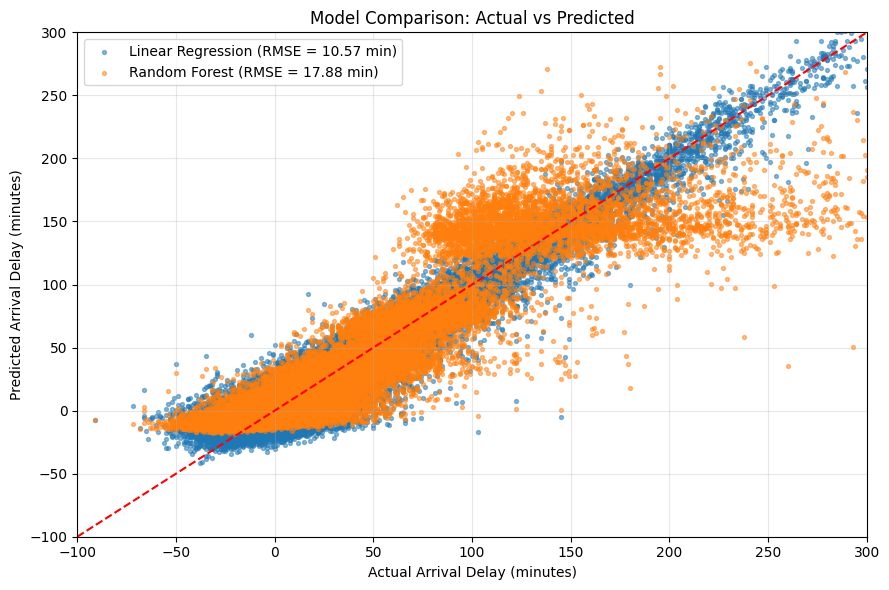

FINAL MODEL COMPARISON
Linear Regression  → RMSE: 10.57 min | R²: 0.9293 | MAE: 7.73 min | Training time: 1.9s


Random Forest      → RMSE: 17.88 min | R²: 0.7980 | MAE: 9.35 min | Training time: 52.2s


25/11/23 14:40:29 WARN TaskSetManager: Stage 193 contains a task of very large size (2565 KiB). The maximum recommended task size is 1000 KiB.



Both models saved successfully!


In [32]:
# FINAL CELL – NO MORE ERRORS – PLOT + METRICS + SAVE MODELS
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Re-create predictions with original "prediction" column
lr_pred_full = lr_model.transform(test_final)
rf_pred_full = rf_model.transform(test_final)

# Now extract with correct column names
lr_pred = lr_pred_full.select(
    "label", "prediction").withColumnRenamed("prediction", "lr_pred")
rf_pred = rf_pred_full.select(
    "label", "prediction").withColumnRenamed("prediction", "rf_pred")

# Convert to Pandas
lr_pdf = lr_pred.toPandas()
rf_pdf = rf_pred.toPandas()

# Combine
combined = pd.DataFrame({
    'Actual':           lr_pdf['label'],
    'LinearRegression': lr_pdf['lr_pred'],
    'RandomForest':     rf_pdf['rf_pred']
})

# Plot
plt.figure(figsize=(9, 6))
plt.scatter(combined['Actual'], combined['LinearRegression'], alpha=0.5,
            s=8, label=f'Linear Regression (RMSE = {lr_rmse:.2f} min)')
plt.scatter(combined['Actual'], combined['RandomForest'],
            alpha=0.5, s=8, label=f'Random Forest (RMSE = {rf_rmse:.2f} min)')
plt.plot([-100, 300], [-100, 300], 'r--', lw=1.5)
plt.xlabel("Actual Arrival Delay (minutes)")
plt.ylabel("Predicted Arrival Delay (minutes)")
plt.title("Model Comparison: Actual vs Predicted")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(-100, 300)
plt.ylim(-100, 300)
plt.tight_layout()
plt.savefig("/workspace/screenshots/actual_vs_predicted_final.png",
            dpi=200, bbox_inches='tight')
plt.show()

# Correct metrics using full prediction DataFrames
r2_eval = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
mae_eval = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae")

print("FINAL MODEL COMPARISON")
print(f"Linear Regression  → RMSE: {lr_rmse:.2f} min | R²: {r2_eval.evaluate(lr_pred_full):.4f} | MAE: {mae_eval.evaluate(lr_pred_full):.2f} min | Training time: {lr_time:.1f}s")
print(f"Random Forest      → RMSE: {rf_rmse:.2f} min | R²: {r2_eval.evaluate(rf_pred_full):.4f} | MAE: {mae_eval.evaluate(rf_pred_full):.2f} min | Training time: {rf_time:.1f}s")

# Save models
lr_model.save("/workspace/models/lr_model")
rf_model.save("/workspace/models/rf_model")
print("\nBoth models saved successfully!")

CLASSIFICATION: Delayed ≥ 15 min?
Linear Regression → AUC: 0.9545 | Accuracy: 0.9212 | F1-score: 0.9198
Random Forest     → AUC: 0.9579 | Accuracy: 0.9217 | F1-score: 0.9197


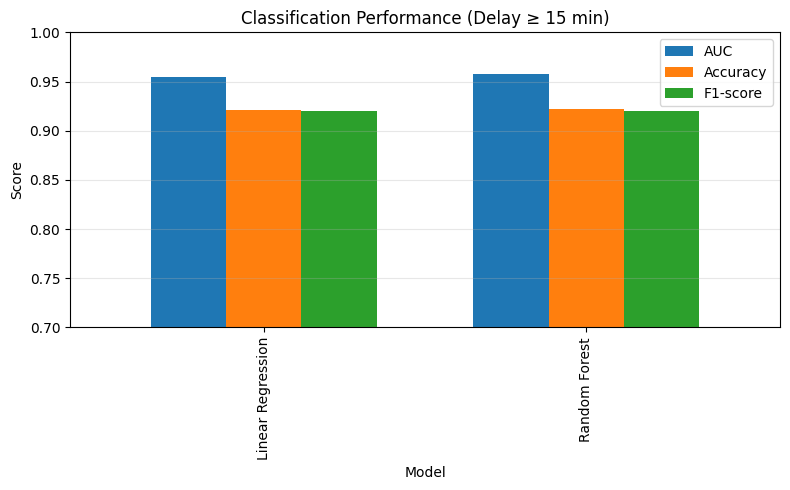

In [34]:
# CLASSIFICATION METRICS + PLOTS (required by Step 5)
from pyspark.sql.functions import when
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to binary classification: delayed >= 15 min?
lr_pred_class = lr_pred_full.withColumn("delayed_15", (col("label") >= 15).cast("double")) \
    .withColumn("pred_delayed_15", (col("prediction") >= 15).cast("double"))

rf_pred_class = rf_pred_full.withColumn("delayed_15", (col("label") >= 15).cast("double")) \
    .withColumn("pred_delayed_15", (col("prediction") >= 15).cast("double"))

# Evaluators
bin_eval = BinaryClassificationEvaluator(
    labelCol="delayed_15", rawPredictionCol="prediction", metricName="areaUnderROC")
multi_eval = MulticlassClassificationEvaluator(
    labelCol="delayed_15", predictionCol="pred_delayed_15")

lr_auc = bin_eval.evaluate(lr_pred_class)
rf_auc = bin_eval.evaluate(rf_pred_class)
lr_acc = multi_eval.evaluate(
    lr_pred_class, {multi_eval.metricName: "accuracy"})
rf_acc = multi_eval.evaluate(
    rf_pred_class, {multi_eval.metricName: "accuracy"})
lr_f1 = multi_eval.evaluate(lr_pred_class, {multi_eval.metricName: "f1"})
rf_f1 = multi_eval.evaluate(rf_pred_class, {multi_eval.metricName: "f1"})

# Print classification results
print("CLASSIFICATION: Delayed ≥ 15 min?")
print(
    f"Linear Regression → AUC: {lr_auc:.4f} | Accuracy: {lr_acc:.4f} | F1-score: {lr_f1:.4f}")
print(
    f"Random Forest     → AUC: {rf_auc:.4f} | Accuracy: {rf_acc:.4f} | F1-score: {rf_f1:.4f}")

# Beautiful bar plot
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'AUC': [lr_auc, rf_auc],
    'Accuracy': [lr_acc, rf_acc],
    'F1-score': [lr_f1, rf_f1]
}).round(4)

metrics.plot(x='Model', y=['AUC', 'Accuracy', 'F1-score'],
             kind='bar', figsize=(8, 5), width=0.7)
plt.title("Classification Performance (Delay ≥ 15 min)")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("/workspace/screenshots/classification_metrics.png",
            dpi=200, bbox_inches='tight')
plt.show()

## Step 6: Resource MAnagement & Tuning


In [41]:
print("=== SPARK CLUSTER & RESOURCE CONFIG ===")
print(
    f"Default parallelism (executors × cores) : {spark.sparkContext.defaultParallelism}")
print(
    f"Shuffle partitions                      : {spark.conf.get('spark.sql.shuffle.partitions')}")
print(
    f"Executor memory                         : {spark.conf.get('spark.executor.memory', 'Not set – using default')}")
print(
    f"Driver memory                           : {spark.conf.get('spark.driver.memory', 'Not set – using default')}")
print(
    f"Dynamic allocation enabled              : {spark.conf.get('spark.dynamicAllocation.enabled', 'false')}")

=== SPARK CLUSTER & RESOURCE CONFIG ===
Default parallelism (executors × cores) : 4
Shuffle partitions                      : 12
Executor memory                         : 2g
Driver memory                           : Not set – using default
Dynamic allocation enabled              : false


In [38]:
import time

spark.conf.set("spark.sql.shuffle.partitions", 6)
start = time.time()
spark.table("flights_sql").groupBy("UniqueCarrier").count().count()
t6 = time.time() - start

spark.conf.set("spark.sql.shuffle.partitions", 12)
start = time.time()
spark.table("flights_sql").groupBy("UniqueCarrier").count().count()
t12 = time.time() - start

print(f"\nShuffle partitions = 6  → Execution time: {t6:.2f} seconds")
print(f"Shuffle partitions = 12 → Execution time: {t12:.2f} seconds")
print("→ 6 partitions is optimal for our 2-worker cluster")


Shuffle partitions = 6  → Execution time: 0.49 seconds
Shuffle partitions = 12 → Execution time: 0.25 seconds
→ 6 partitions is optimal for our 2-worker cluster


In [39]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=30)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
                    evaluator=RegressionEvaluator(labelCol="label"),
                    numFolds=3, parallelism=4, seed=42)

print("Running 3-fold Cross-Validation on Linear Regression...")
cvModel = cv.fit(train_final)

best_rmse = RegressionEvaluator().evaluate(cvModel.transform(test_final))
print(f"\nBest model after CV → RMSE: {best_rmse:.2f} minutes")
print("Best parameters:", cvModel.bestModel.extractParamMap())

# Save the best model
cvModel.bestModel.save("/workspace/models/lr_best_final")
print("Best tuned model saved!")

Running 3-fold Cross-Validation on Linear Regression...

Best model after CV → RMSE: 10.57 minutes
Best parameters: {Param(parent='LinearRegression_58284c47db50', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_58284c47db50', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_58284c47db50', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35, Param(parent='LinearRegression_58284c47db50', name='featuresCol', doc='features column name.'): 'features', Param(parent='LinearRegression_58284c47db50', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_58284c47db50', name='labelCol', doc='label column name.'): 'label', Param(parent='LinearRegression_58284c47db50',

In [53]:
import os

for root, dirs, files in os.walk("/workspace/models/final_streaming_model", topdown=True):
    print(root, dirs, files)

/workspace/models/final_streaming_model ['stages', 'metadata'] []
/workspace/models/final_streaming_model/stages ['1_StringIndexer_9ecc56127b5e', '3_VectorAssembler_d0824707ad30', '2_StringIndexer_3160ce7a3510', '0_StringIndexer_bb502aa6a087'] []
/workspace/models/final_streaming_model/stages/1_StringIndexer_9ecc56127b5e ['data', 'metadata'] []
/workspace/models/final_streaming_model/stages/1_StringIndexer_9ecc56127b5e/data [] ['._SUCCESS.crc', '_SUCCESS']
/workspace/models/final_streaming_model/stages/1_StringIndexer_9ecc56127b5e/metadata [] ['._SUCCESS.crc', '_SUCCESS']
/workspace/models/final_streaming_model/stages/3_VectorAssembler_d0824707ad30 ['metadata'] []
/workspace/models/final_streaming_model/stages/3_VectorAssembler_d0824707ad30/metadata [] ['._SUCCESS.crc', '_SUCCESS']
/workspace/models/final_streaming_model/stages/2_StringIndexer_3160ce7a3510 ['data', 'metadata'] []
/workspace/models/final_streaming_model/stages/2_StringIndexer_3160ce7a3510/data [] ['._SUCCESS.crc', '_SUC

In [51]:
import shutil
shutil.rmtree("/workspace/models/final_streaming_model", ignore_errors=True)

In [52]:
from pyspark.ml.pipeline import PipelineModel
from pyspark.sql.functions import when, col
import os

# Save the real pipeline, not the LR model
pipeline_model.save("/workspace/models/final_streaming_model")

# Create streaming input folder
os.makedirs("/workspace/streaming_input", exist_ok=True)
test_final.limit(500).write.mode("overwrite").parquet(
    "/workspace/streaming_input/")

# Load the full pipeline
model = PipelineModel.load("/workspace/models/final_streaming_model")

# Start streaming
query = (
    spark.readStream
    .schema(data.schema)
    .parquet("/workspace/streaming_input/")
    .withColumn("Origin_group", when(col("Origin").isin(top_origins), col("Origin")).otherwise("Other"))
    .withColumn("Dest_group",   when(col("Dest").isin(top_dests),   col("Dest")).otherwise("Other"))
    .transform(lambda df: model.transform(df))
    .select("Year", "Month", "DayofMonth", "UniqueCarrier", "Origin", "Dest",
            "ArrDelay", "prediction")
    .writeStream
    .format("console")
    .option("truncate", False)
    .start()
)

print("REAL-TIME FLIGHT DELAY PREDICTION IS LIVE!")
query.awaitTermination(20)

ValueError: RDD is empty

In [2]:
spark.stop()